In [405]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as ss

from scipy.special import erf

In [406]:
df = pd.read_csv(
    r"data\FB\cleaned_data\FB_2019-01-03_34200000_57600000_orderbook_10.csv"
)

#                                          Year-month-day hour:min:sec:frac
df.DateTime = pd.to_datetime(df.DateTime, format = r"%Y-%m-%d %H:%M:%S:%f")

In [407]:
df.head()

,DateTime,Event_Type,Order_ID,Size,Price,Direction,Ask_Price_Level_1,Ask_Volume_Level_1,Bid_Price_Level_1,Bid_Volume_Level_1,...,Bid_Price_Level_8,Bid_Volume_Level_8,Ask_Price_Level_9,Ask_Volume_Level_9,Bid_Price_Level_9,Bid_Volume_Level_9,Ask_Price_Level_10,Ask_Volume_Level_10,Bid_Price_Level_10,Bid_Volume_Level_10
0,2019-01-03 09:30:00.690212,1,7611690.0,10,1348100.0,-1,134.80,30,134.50,630,...,134.1,203,135.00,3781,133.99,1,135.09,25,133.90,80
1,2019-01-03 09:30:00.690246,1,7611990.0,100,1347800.0,-1,134.78,100,134.50,630,...,134.1,203,134.99,100,133.99,1,135.00,3781,133.90,80
2,2019-01-03 09:30:00.690267,3,7611690.0,10,1348100.0,-1,134.78,100,134.50,630,...,134.1,203,135.00,3781,133.99,1,135.09,25,133.90,80
3,2019-01-03 09:30:00.690272,1,7612006.0,100,1347800.0,-1,134.78,200,134.50,630,...,134.1,203,135.00,3781,133.99,1,135.09,25,133.90,80
4,2019-01-03 09:30:00.690741,1,7612154.0,6,1345800.0,1,134.78,200,134.58,6,...,134.2,21,135.00,3781,134.10,203,135.09,25,133.99,1


In [408]:
df["Mid_Price"] = (df.Ask_Price_Level_1 + df.Bid_Price_Level_1) / 2
df["Spread"] = df.Ask_Price_Level_1 - df.Bid_Price_Level_1

In [474]:
df.set_index(pd.to_datetime(
    df.DateTime,
    format = r"%Y-%M-%d %H:%M:%S:%f"
), inplace = True)

df_regrouped = df.groupby(pd.Grouper(
    key = "DateTime",
    freq = "1S"
))

df_resampled = df.resample(
    "1S",
    on = "DateTime"
)

df_regrouped.__class__
df_resampled.__class__

# mid_price = df.Mid_Price
# resampling = mid_price.resample("300S", label = "left").mean()
# rollingx    = mid_price.rolling("300S").mean()

# print(len(resampling))
# print(len(rollingx))

# plt.plot(mid_price)
# plt.plot(resampling, label = "resampling")
# plt.plot(rollingx, label = "rolling")
# plt.legend()

# plt.show()

pandas.core.resample.DatetimeIndexResampler

In [472]:
bin_size = "10s"
df_regrouped = df.groupby(pd.Grouper(
    key = "DateTime",
    freq = bin_size
))

# df_regrouped = df.resample(
#     "10S",
#     on = "DateTime"
# )


trades_count = []
open_mid = []
high_mid = []
low_mid = []
close_mid = []
missing_count = 0

for block in df_regrouped:
    temp = block[1]
    if len(temp) > 0:
        trades_count.append(len(temp))
        open_mid.append(temp.Mid_Price.to_numpy()[0])
        high_mid.append(temp.Mid_Price.to_numpy().max())
        low_mid.append(temp.Mid_Price.to_numpy().min())
        close_mid.append(temp.Mid_Price.to_numpy()[-1])
    else:
        missing_count += 1

ohlc = pd.DataFrame({
    "Open" : open_mid,
    "High" : high_mid,
    "Low" : low_mid,
    "Close" : close_mid
})

print(f"Average bins length: {round(np.mean(trades_count), 2)} ticks.")
print(f"Std bins' length: {round(np.std(trades_count), 2)} ticks.")
print(f"Number of missing bins (={bin_size}) in one trading day: {missing_count}")
print(f"Average mid price: {round(np.mean(close_mid), 2)}$")

Average bins length: 334.97 ticks.
Std bins' length: 230.97 ticks.
Number of missing bins (=10s) in one trading day: 0
Average mid price: 132.93$


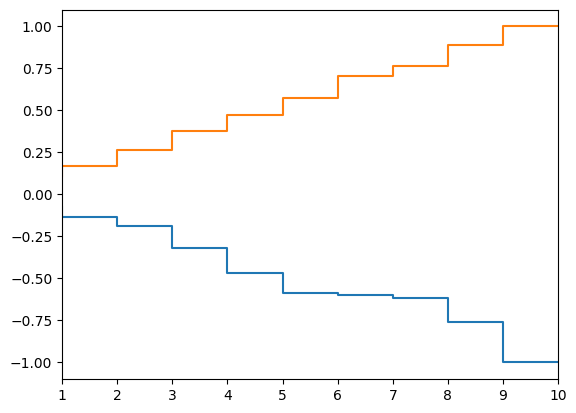

In [ ]:
sample_slice = df.sample()

ask_price = sample_slice.filter(like = "Ask_Price").to_numpy().flatten()
ask_vol = sample_slice.filter(like = "Ask_Volume").to_numpy().flatten()
bid_price = sample_slice.filter(like = "Bid_Price").to_numpy().flatten()
bid_vol = sample_slice.filter(like = "Bid_Volume").to_numpy().flatten()

levels = range(1, 11)
ask_vol_frac = ask_vol.cumsum() / ask_vol.sum()
bid_vol_frac = bid_vol.cumsum() / bid_vol.sum()
ask_vol_frac *= -1

# plt.bar(ask_price, ask_vol, width = 0.005)
# plt.bar(bid_price, bid_vol, width = 0.005)

plt.step(levels, ask_vol_frac)
plt.step(levels, bid_vol_frac)
plt.xlim(1,10)

plt.show()

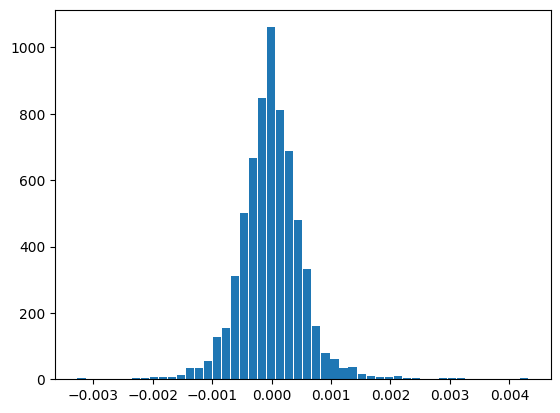

In [ ]:
log_rets = np.log(ohlc.Close).diff()[1:]

plt.hist(log_rets, density = True, bins = 50, rwidth = 0.9)
plt.show()

In [ ]:
# df_indexed = df.set_index(pd.to_datetime(
#     df.DateTime,
#     unit = "s"
# ))

resampled_obj = df_indexed.resample("1s")

for item in resampled_obj:
    print(item[1].head())
    break

                                             DateTime  Event_Type   Order_ID  \
DateTime                                                                       
2019-01-03 09:30:00.690212 2019-01-03 09:30:00.690212           1  7611690.0   
2019-01-03 09:30:00.690246 2019-01-03 09:30:00.690246           1  7611990.0   
2019-01-03 09:30:00.690267 2019-01-03 09:30:00.690267           3  7611690.0   
2019-01-03 09:30:00.690272 2019-01-03 09:30:00.690272           1  7612006.0   
2019-01-03 09:30:00.690741 2019-01-03 09:30:00.690741           1  7612154.0   

                            Size      Price  Direction  Ask_Price_Level_1  \
DateTime                                                                    
2019-01-03 09:30:00.690212    10  1348100.0         -1             134.80   
2019-01-03 09:30:00.690246   100  1347800.0         -1             134.78   
2019-01-03 09:30:00.690267    10  1348100.0         -1             134.78   
2019-01-03 09:30:00.690272   100  1347800.0         -1

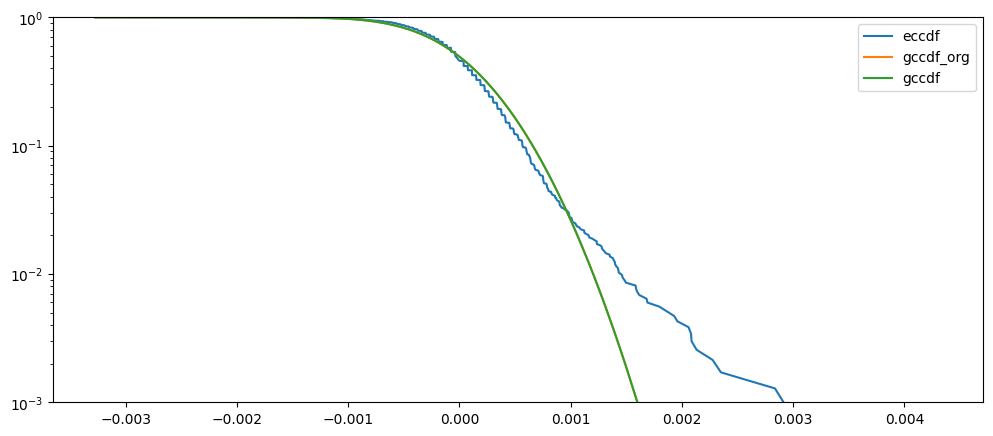

(2136,)
(2339,)
(2339,)


In [ ]:
def empirical_ccdf(arr):
    N = len(arr)
    arr = np.sort(arr)
    x, count = np.unique(arr, return_counts = True)
    cumcount = np.cumsum(count)
    cdf = cumcount / N
    ccdf = 1 - cdf
    return x, ccdf

def gaussian_ccdf_original(data):
    x = np.array(sorted(data))
    N = len(data)
    mean = sum(data)/N
    std = np.sqrt(sum((data-mean)**2)/N)
    c = 0.5*(1 - erf((x-mean)/(std*np.sqrt(2))))
    return x, c

def gaussian_ccdf(arr):
    N = len(arr)
    x = np.sort(arr)
    mu = x.mean()
    sigma = x.std()
    cdf = ss.norm.cdf(x, mu, sigma)
    ccdf = 1 - cdf
    return x, ccdf

x1, y1 = empirical_ccdf(log_rets)
x2, y2 = gaussian_ccdf_original(log_rets)
x3, y3 = gaussian_ccdf(log_rets)

plt.figure(figsize = (12, 5), clear = True)
plt.semilogy(x1, y1, label = "eccdf")
plt.semilogy(x2, y2, label = "gccdf_org")
plt.semilogy(x3, y3, label = "gccdf")
plt.ylim(10e-4, 1)
plt.legend()
plt.show()

print(x1.shape)
print(x2.shape)
print(x3.shape)

In [ ]:
ss.kurtosis(log_rets)

5.4012577244907956

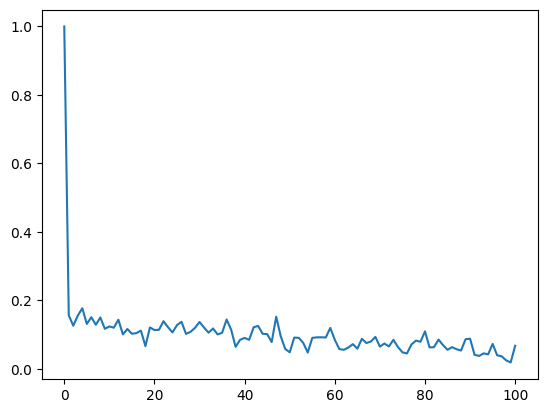

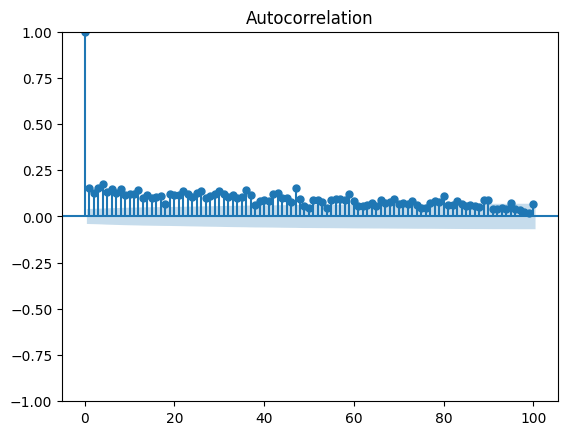

In [ ]:
plt.plot(sm.tsa.acf(log_rets.abs(), nlags = 100))
sm.graphics.tsa.plot_acf(log_rets.abs(), lags = 100, alpha = 0.05)
plt.show()

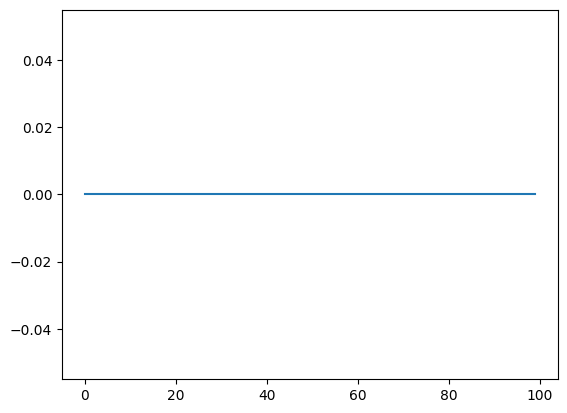

In [ ]:
lr_normalised = log_rets - log_rets.mean()
lr_normalised = lr_normalised.to_numpy()

var = lr_normalised.var()
lags = 100
vrgm = [0] * lags
vrgm[0] = 0

for lag in range(1, lags):
    vrgm[lag] = np.mean((lr_normalised[lag:] - lr_normalised[:-lag])**2) / (2 * var)


lags = range(100)
vvalues = len(lags) * [0]

for l in lags:
    c = 1

    if l > 0:
        tmp = []
        for i in range(len(lr_normalised) - l):
            tmp.append((lr_normalised[l:][i] - lr_normalised[:-l][i])**2)
        c = sum(tmp) / (2 * len(lr_normalised)) / var


# plt.plot(vrgm)
plt.plot(vvalues)
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'diff'